# HUST机器学习结课报告

## 基于语音识别的性别识别

### 校交1802李俊
---

## Part 1 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import time

%matplotlib inline
# 读入数据
data = pd.read_csv("voice.csv")
print ("data read successfully.")
data.head(7)

data read successfully.


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,1.932562,8.308895,0.963181,0.738307,...,0.132786,0.110132,0.017112,0.253968,0.298222,0.007812,2.726562,2.718750,0.125160,male
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,1.530643,5.987498,0.967573,0.762638,...,0.150762,0.105945,0.026230,0.266667,0.479620,0.007812,5.312500,5.304688,0.123992,male


In [2]:
class SVM(object):
    """
    SVM model
    """
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=0.00001):
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.kernel_func_list = {
            'linear': self._kernel_linear,
            'quadratic': self._kernel_quadratic,
        }
        self.kernel_func = self.kernel_func_list[kernel_type]
        self.C = C
        self.epsilon = epsilon
        self.alpha = None

    def train_raw(self, X_train, Y_train):
        """
        Training model
        :param X_train: shape = num_train, dim_feature
        :param Y_train: shape = num_train, 1
        :return: loss_history
        """
        n, d = X_train.shape[0], X_train.shape[1]
        self.alpha = np.zeros(n)
        # Iteration
        for i in range(self.max_iter):
            diff = self._iteration(X_train, Y_train)
            if i % 100 == 0:
                print('Iter %r / %r, Diff %r' % (i, self.max_iter, diff))
            if diff < self.epsilon:
                break

    def predict_raw(self, X):
        return np.dot(self.w.T, X.T) + self.b

    def predict(self, X):
        return np.sign(np.dot(self.w.T, X.T) + self.b).astype(int)

    def _iteration(self, X_train, Y_train):
        alpha = self.alpha
        alpha_prev = np.copy(alpha)
        n = alpha.shape[0]
        for j in range(n):
            # Find i not equal to j randomly
            i = j
            for _ in range(1000):
                if i != j:
                    break
                i = random.randint(0, n - 1)
            x_i, x_j, y_i, y_j = X_train[i, :], X_train[j, :], Y_train[i], Y_train[j]
            # Define the similarity of instances. K11 + K22 - 2K12
            k_ij = self.kernel_func(x_i, x_i) + self.kernel_func(x_j, x_j) - 2 * self.kernel_func(x_i, x_j)
            if k_ij == 0:
                continue
            a_i, a_j = alpha[i], alpha[j]
            # Calculate the boundary of alpha
            L, H = self._cal_L_H(self.C, a_j, a_i, y_j, y_i)
            # Calculate model parameters
            self.w = np.dot(X_train.T, np.multiply(alpha, Y_train))
            self.b = np.mean(Y_train - np.dot(self.w.T, X_train.T))
            # Iterate alpha_j and alpha_i according to 'Delta W(a_j)'
            E_i = self.predict(x_i) - y_i
            E_j = self.predict(x_j) - y_j
            alpha[j] = a_j + (y_j * (E_i - E_j) * 1.0) / k_ij
            alpha[j] = min(H, max(L, alpha[j]))
            alpha[i] = a_i + y_i * y_j * (a_j - alpha[j])
        diff = np.linalg.norm(alpha - alpha_prev)
        return diff

    def _kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)

    def _kernel_quadratic(self, x1, x2):
        return np.dot(x1, x2.T) ** 2

    def _cal_L_H(self, C, a_j, a_i, y_j, y_i):
        if y_i != y_j:
            L = max(0, a_j - a_i)
            H = min(C, C - a_i + a_j)
        else:
            L = max(0, a_i + a_j - C)
            H = min(C, a_i + a_j)
        return L, H

def _GenerateData():
    k, m, n_train, n_val = 5, 2, 5, 2
    X_train, X_val, Y_train, Y_val = [], [], [], []
    color = ['c', 'g', 'b', 'r']
    def _generateOne(X, Y, i):
        x, y, l = random.uniform((int(i / 2) + 0.1) * 10, (int(i / 2) + 0.9) * 10), random.uniform((i % 2 * 0.5 + 0.1) * 10, (i % 2 * 0.5 + 0.9) * 10), i
        X.append((x, y))
        Y.append((i - 0.5)*2)
        return x, y
    for i_ in range(m):
        for _ in range(n_train):
            x_, y_ = _generateOne(X_train, Y_train, i_)
            plt.scatter(x_, y_, s=100, c=color[i_])
        for _ in range(n_val):
            _generateOne(X_val, X_val, i_)

    return np.array(X_train), np.array(X_val), np.array(Y_train), np.array(Y_val)

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [4]:
data.label.unique

<bound method Series.unique of 0         male
1         male
2         male
3         male
4         male
         ...  
3163    female
3164    female
3165    female
3166    female
3167    female
Name: label, Length: 3168, dtype: object>

In [5]:
 data.label=[1 if each =="female" else 0 for each in data.label]
 data.label.values

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [6]:
 data.head(6)#first six

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,0
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,0
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,0
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,0
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,0
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,1.932562,8.308895,0.963181,0.738307,...,0.132786,0.110132,0.017112,0.253968,0.298222,0.007812,2.726562,2.718750,0.125160,0


In [7]:
y=data.label.values
x_data=data.drop(['label'],axis=1)

In [8]:
np.min(x_data)

meanfreq    0.039363
sd          0.018363
median      0.010975
Q25         0.000229
Q75         0.042946
IQR         0.014558
skew        0.141735
kurt        2.068455
sp.ent      0.738651
sfm         0.036876
mode        0.000000
centroid    0.039363
meanfun     0.055565
minfun      0.009775
maxfun      0.103093
meandom     0.007812
mindom      0.004883
maxdom      0.007812
dfrange     0.000000
modindx     0.000000
dtype: float64

In [9]:
np.max(x_data)

meanfreq       0.251124
sd             0.115273
median         0.261224
Q25            0.247347
Q75            0.273469
IQR            0.252225
skew          34.725453
kurt        1309.612887
sp.ent         0.981997
sfm            0.842936
mode           0.280000
centroid       0.251124
meanfun        0.237636
minfun         0.204082
maxfun         0.279114
meandom        2.957682
mindom         0.458984
maxdom        21.867188
dfrange       21.843750
modindx        0.932374
dtype: float64

In [10]:
#normalization
x=(x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data)).values

In [11]:
#train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=42)
#find transpose
x_train=x_train.T
x_test=x_test.T
y_train=y_train.T
y_test=y_test.T
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (20, 2534)
x_test shape: (20, 634)
y_train shape: (2534,)
y_test shape: (634,)


In [12]:
#parameter initialize and sigmoid function
def initialize_weights_and_bias(dimension):
    w=np.full((dimension,1),0.01)
    b=0.0
    return w,b
def sigmoid(z):
    y_head=1/(1+np.exp(-z))
    return y_head

In [13]:
def forward_backward_propagation(w,b,x_train,y_train):
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]    
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] 
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]  
    gradients = {"derivative_weight": derivative_weight, "derivative_bias": derivative_bias}
    
    return cost,gradients

In [14]:
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            
    parameters = {"weight": w,"bias": b}
    return parameters, gradients, cost_list

In [15]:
def predict(w,b,x_test):
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

In [16]:
def main(x_train, y_train, x_test, y_test, learning_rate ,  para):
    # initialize
    model = SVM()
    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,para)
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    print("test accuracy: {} %".format(100 - np.mean(np.abs(-0.1+y_prediction_test - y_test)) * 100))
    
main(x_train, y_train, x_test, y_test,learning_rate = 1, para = 300)

test accuracy: 87.38170347003154 %


## Part 2 

## 1.分析数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# 读入数据
data = pd.read_csv("voice.csv")
print ("data read successfully.")
data.head(7)

data read successfully.


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,1.932562,8.308895,0.963181,0.738307,...,0.132786,0.110132,0.017112,0.253968,0.298222,0.007812,2.726562,2.718750,0.125160,male
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,1.530643,5.987498,0.967573,0.762638,...,0.150762,0.105945,0.026230,0.266667,0.479620,0.007812,5.312500,5.304688,0.123992,male


In [2]:
data.corr()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
meanfreq,1.000000,-0.739039,0.925445,0.911416,0.740997,-0.627605,-0.322327,-0.316036,-0.601203,-0.784332,0.687715,1.000000,0.460844,0.383937,0.274004,0.536666,0.229261,0.519528,0.515570,-0.216979
sd,-0.739039,1.000000,-0.562603,-0.846931,-0.161076,0.874660,0.314597,0.346241,0.716620,0.838086,-0.529150,-0.739039,-0.466281,-0.345609,-0.129662,-0.482726,-0.357667,-0.482278,-0.475999,0.122660
median,0.925445,-0.562603,1.000000,0.774922,0.731849,-0.477352,-0.257407,-0.243382,-0.502005,-0.661690,0.677433,0.925445,0.414909,0.337602,0.251328,0.455943,0.191169,0.438919,0.435621,-0.213298
Q25,0.911416,-0.846931,0.774922,1.000000,0.477140,-0.874189,-0.319475,-0.350182,-0.648126,-0.766875,0.591277,0.911416,0.545035,0.320994,0.199841,0.467403,0.302255,0.459683,0.454394,-0.141377
Q75,0.740997,-0.161076,0.731849,0.477140,1.000000,0.009636,-0.206339,-0.148881,-0.174905,-0.378198,0.486857,0.740997,0.155091,0.258002,0.285584,0.359181,-0.023750,0.335114,0.335648,-0.216475
IQR,-0.627605,0.874660,-0.477352,-0.874189,0.009636,1.000000,0.249497,0.316185,0.640813,0.663601,-0.403764,-0.627605,-0.534462,-0.222680,-0.069588,-0.333362,-0.357037,-0.337877,-0.331563,0.041252
skew,-0.322327,0.314597,-0.257407,-0.319475,-0.206339,0.249497,1.000000,0.977020,-0.195459,0.079694,-0.434859,-0.322327,-0.167668,-0.216954,-0.080861,-0.336848,-0.061608,-0.305651,-0.304640,-0.169325
kurt,-0.316036,0.346241,-0.243382,-0.350182,-0.148881,0.316185,0.977020,1.000000,-0.127644,0.109884,-0.406722,-0.316036,-0.194560,-0.203201,-0.045667,-0.303234,-0.103313,-0.274500,-0.272729,-0.205539
sp.ent,-0.601203,0.716620,-0.502005,-0.648126,-0.174905,0.640813,-0.195459,-0.127644,1.000000,0.866411,-0.325298,-0.601203,-0.513194,-0.305826,-0.120738,-0.293562,-0.294869,-0.324253,-0.319054,0.198074
sfm,-0.784332,0.838086,-0.661690,-0.766875,-0.378198,0.663601,0.079694,0.109884,0.866411,1.000000,-0.485913,-0.784332,-0.421066,-0.362100,-0.192369,-0.428442,-0.289593,-0.436649,-0.431580,0.211477


In [3]:
data.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

In [4]:
print ('Total number of samples:{}'.format(data.shape[0]))
print ('Total number of male:{}'.format(data[data.label == 'male'].shape[0]))
print ('Total number of female:{}'.format(data[data.label == 'female'].shape[0]))

Total number of samples:3168
Total number of male:1584
Total number of female:1584


## 2.可视化数据

将特征两两配对，查看性别关于所有特征对的分布。将分布图保存在figure的文件夹下。

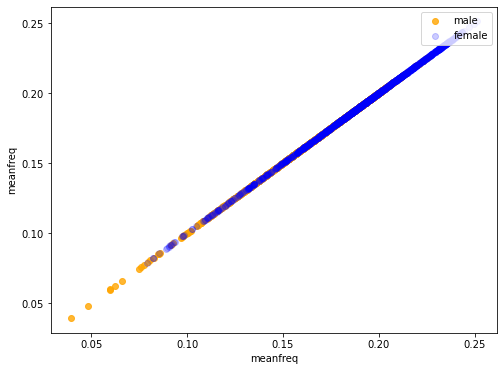

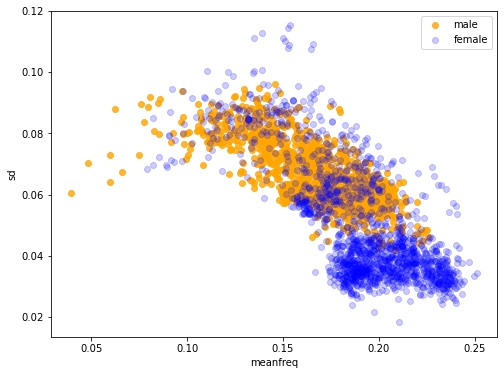

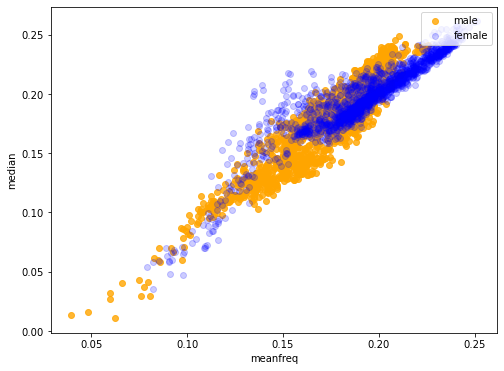

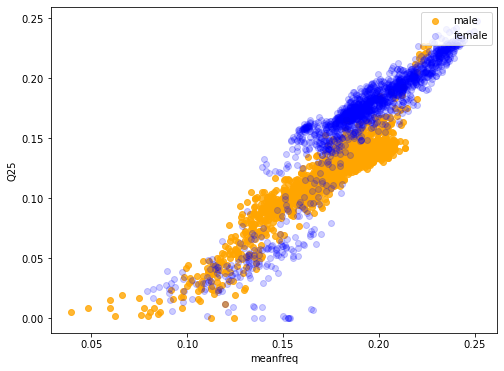

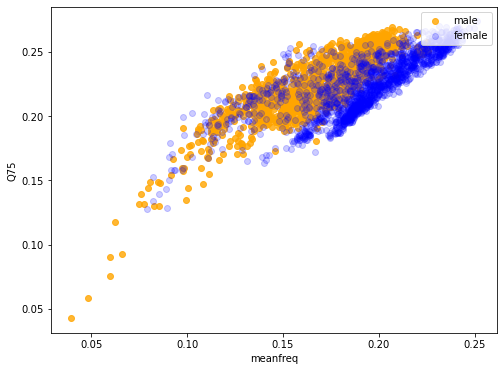

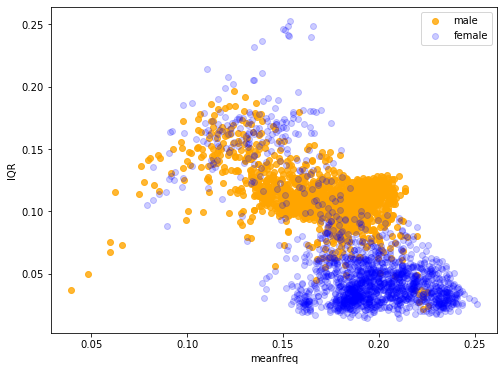

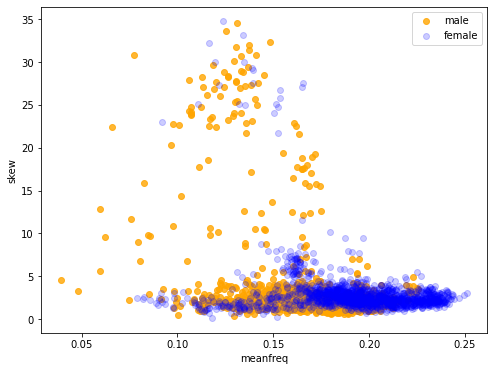

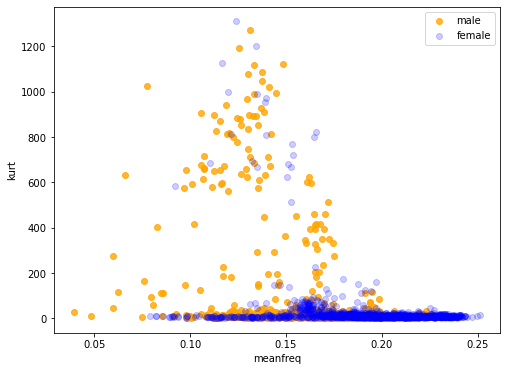

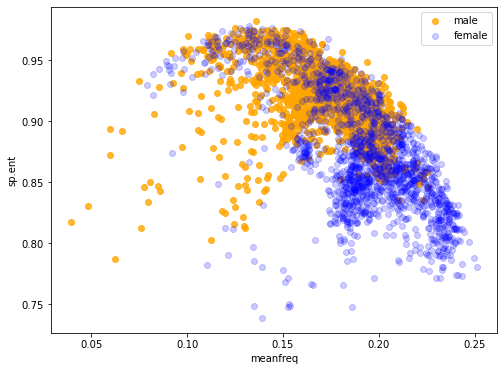

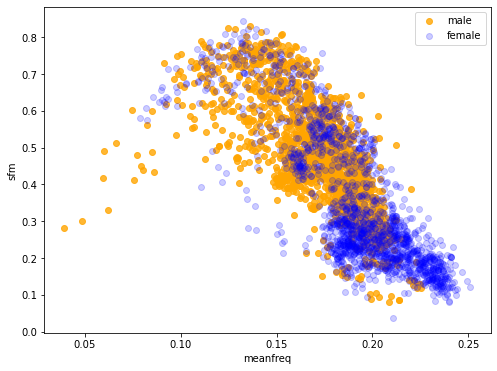

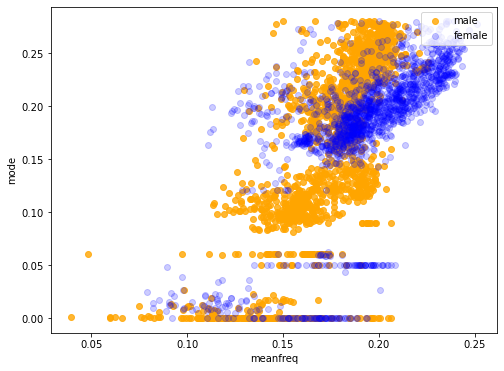

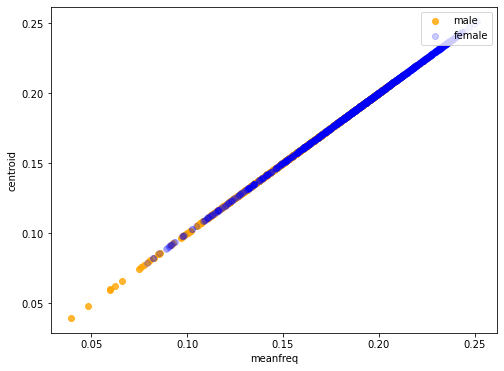

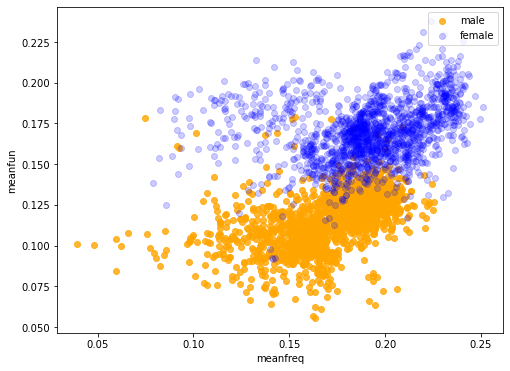

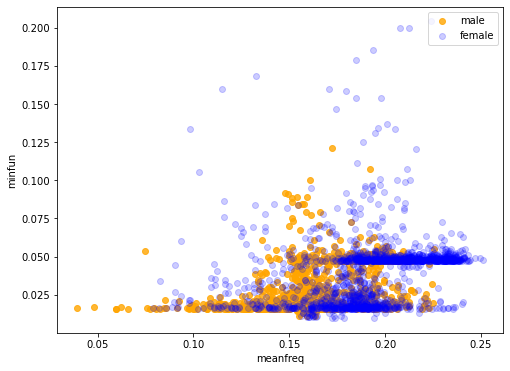

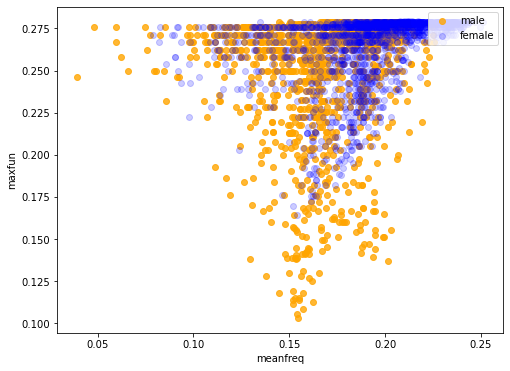

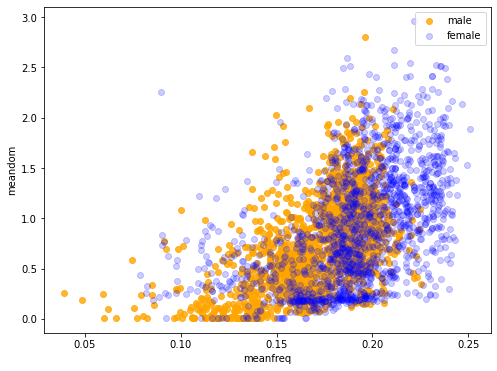

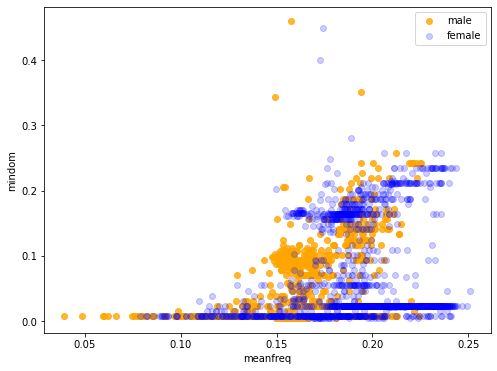

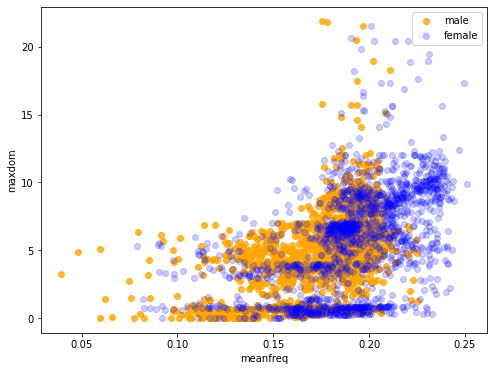

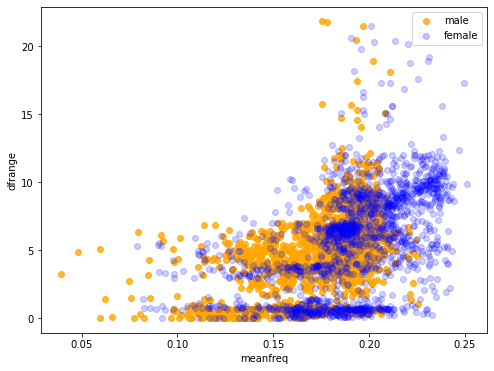

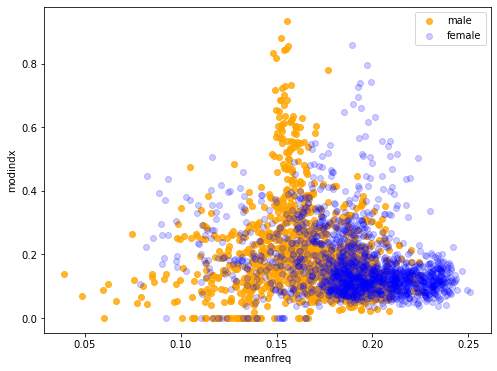

In [5]:
import os

def show_relevence():
    # 以两个特征为一组查看样本分布
    data = pd.read_csv("voice.csv")
    female = data[data.label == 'female']
    male = data[data.label == 'male']
    indices = list(data.drop(['label'], axis=1).columns)
    if not os.path.exists('figure'):
        os.mkdir('figure')
    for feature_x in indices:
        for feature_y in indices[indices.index(feature_x):]:
            plt.figure(figsize=(8,6))
            X = male[feature_x]
            Y = male[feature_y]
            plt.scatter(X, Y, c='orange', label='male', alpha = 0.8)
            
            X = female[feature_x]
            Y = female[feature_y]
            plt.scatter(X, Y, c='blue', label='female', alpha = 0.2)
            
            plt.xlabel(feature_x)
            plt.ylabel(feature_y)
            plt.legend(loc='upper right')
            #plt.show()            
            plt.savefig('figure/{}-{}.png'.format(feature_x, feature_y))
            
        break

              
show_relevence()

## 3.数据预处理

In [6]:
from sklearn.utils import shuffle

# 打乱原始数据顺序
data = shuffle(data, random_state=0)

gender = data.label
features = data.drop(['label'], axis=1)
print ("data is ready.")

data is ready.


### 3.1标准化数据

In [7]:
from sklearn.preprocessing import StandardScaler

def standard_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

features = standard_data(features)
print ("data has been standarded.")

data has been standarded.


### 3.2划分训练集和测试集

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
        train_test_split(features, gender, train_size = 0.80, random_state = 0)
print ("Training and testing split was successful")

Training and testing split was successful


## 4.训练模型

In [9]:
from sklearn.metrics import accuracy_score


def train_clf(clf, X_train, y_train):
    clf.fit(X_train,y_train)
    print ("Classifier trained successfully.")

def predict_labels(clf, features):
    y_pred = clf.predict(features)
    return y_pred
    
def train_predict(clf, X_train, y_train, X_test, y_test):
    
    # 输出训练器名称
    print ("Classifier：{}....".format(clf.__class__.__name__))
    
    # 训练一个分类器
    train_clf(clf, X_train, y_train)
    
    # 输出训练集和训练集预测结果
    print ("Accuracy for train set: {}".format(accuracy_score(y_train, predict_labels(clf, X_train))))
    print ("Accuarcy for test set: {}".format(accuracy_score(y_test, predict_labels(clf, X_test))))


### 4.1基准对比

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

clf_A = RandomForestClassifier(n_estimators=10)
clf_B = DecisionTreeClassifier()
clf_C = svm.SVC(gamma='auto')

for clf in clf_A, clf_B, clf_C:
    train_predict(clf, X_train, y_train, X_test, y_test)

Classifier：RandomForestClassifier....
Classifier trained successfully.
Accuracy for train set: 0.999605367008682
Accuarcy for test set: 0.9763406940063092
Classifier：DecisionTreeClassifier....
Classifier trained successfully.
Accuracy for train set: 1.0
Accuarcy for test set: 0.9558359621451105
Classifier：SVC....
Classifier trained successfully.
Accuracy for train set: 0.9850039463299132
Accuarcy for test set: 0.9842271293375394


## 5.调试支持向量机模型

### 5.1对比核函数对模型影响

In [11]:
from sklearn.model_selection import cross_val_score

# 核函数列表
kernels = ['linear', 'rbf', 'poly']
acc_score = []
for k in kernels:
    svc= svm.SVC(kernel=k, gamma='auto')
    scores = cross_val_score(svc, features, gender, cv=5 ,scoring='accuracy')
    acc_score.append(np.mean(scores))

# 输出各个核函数得分
print ('The accuracy of SVM with linear kernel: ', acc_score[0])
print ('The accuracy of SVM with rbf kernel: ', acc_score[1])
print ('The accuracy of SVM with poly kernel: ', acc_score[2])

The accuracy of SVM with linear kernel:  0.9734876013257198
The accuracy of SVM with rbf kernel:  0.9813780297887634
The accuracy of SVM with poly kernel:  0.9589695723355828


### 5.2调试参数C

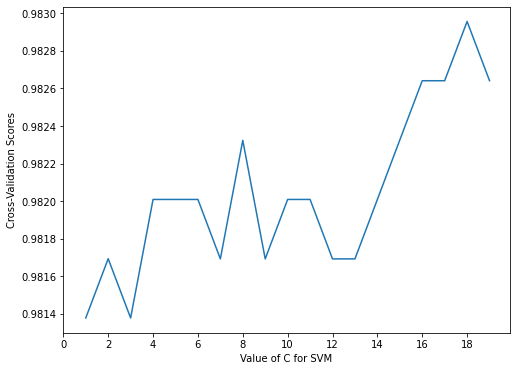

In [12]:
%matplotlib inline

from sklearn.model_selection import cross_val_score

# C的取值范围
c_range = np.arange(1, 20)
acc_score = []
for c in c_range:
    svc=svm.SVC(kernel='rbf', C=c, gamma='auto')
    scores = cross_val_score(svc, features, gender, cv=5, scoring='accuracy') #cv is cross validation
    acc_score.append(np.mean(scores))
        
# 显示准确率和C的关系
plt.figure(figsize=(8,6))
plt.plot(c_range, acc_score)
plt.xticks(np.arange(0, 20, 2))
plt.xlabel("Value of C for SVM")
plt.ylabel("Cross-Validation Scores")
plt.show()

   从图中可以看出，准确率随着参数C的增大而增大。参数C取值在18左右是准确率达到最大。此时准确率大约为98.30%。接下来将参数C的取值缩小到17.0到19.0之间查看准确率的变化情况。

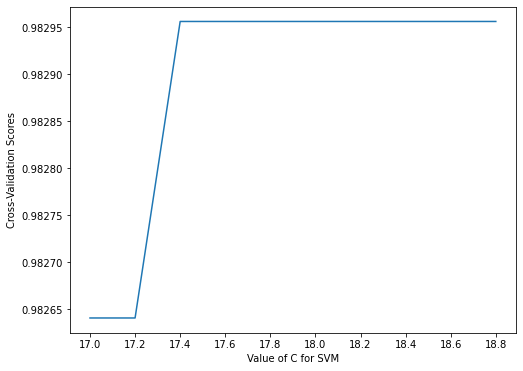

In [13]:
%matplotlib inline

# C的取值范围
c_range = np.arange(17.0, 19.0, 0.2)
acc_score = []
for c in c_range:
    svc=svm.SVC(kernel='rbf', C=c, gamma='auto')
    scores = cross_val_score(svc, features, gender, cv=5, scoring='accuracy') #cv is cross validation
    acc_score.append(np.mean(scores))

# 显示准确率和C的关系
plt.figure(figsize=(8, 6))
plt.plot(c_range, acc_score)
plt.xticks(c_range)
plt.xlabel("Value of C for SVM")
plt.ylabel("Cross-Validation Scores")
plt.show()

参数C在17.4时，模型准确率最高。

### 5.3调试参数gamma

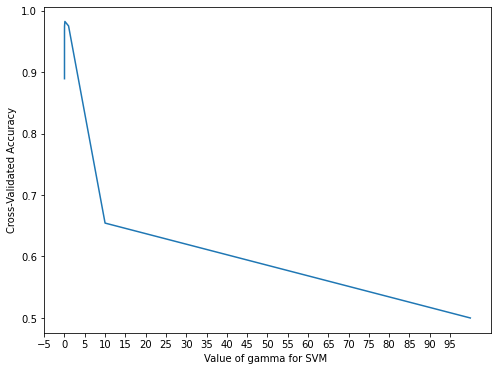

In [14]:
%matplotlib inline

# gamma参数列表
gamma_range=[0.0001,0.001,0.01,0.1,1,10,100]
acc_score = []

for gamma in gamma_range:
    svc = svm.SVC(kernel='rbf', gamma=gamma)
    scores = cross_val_score(svc, features, gender, cv = 5, scoring='accuracy')
    acc_score.append(np.mean(scores))

# 显示准确率和gamma之间的关系
plt.figure(figsize=(8, 6))
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVM ')
plt.xticks(np.arange(-5, 100, 5))
plt.ylabel('Cross-Validated Accuracy')
plt.show()

当gamma取值在0.1左右时，准确率达到最高。接下来将gamma取值限制在0.01到0.15之间，查看准确率。

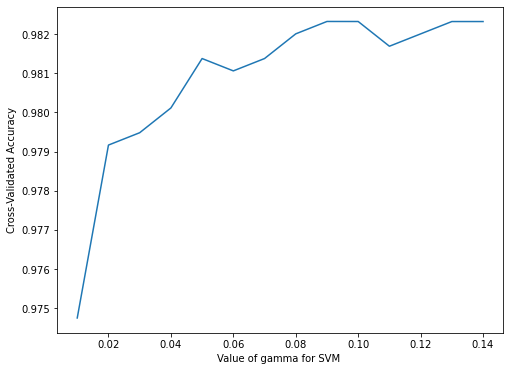

In [15]:
%matplotlib inline

# gamma参数列表
gamma_range = np.arange(0.01, 0.15, 0.01)
acc_score = []
for gamme in gamma_range:
    svc = svm.SVC(kernel='rbf', gamma=gamme)
    scores = cross_val_score(svc, features, gender, cv = 5, scoring='accuracy')
    acc_score.append(np.mean(scores))

# 显示准确率与gamma的关系
plt.figure(figsize=(8, 6))
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVM ')
#plt.xticks(np.arange(-5, 100, 5))
plt.ylabel('Cross-Validated Accuracy')
plt.show()

从图中可以看出,准确率随着参数gamma增大而增大，在gamma等于0.10时达到最大值。此时准确率约为98.20%

### 5.4同时调试多个参数

In [16]:
from sklearn.model_selection import GridSearchCV

# 参数字典
params = tuned_parameters = {
 'C': (np.arange(0.1,1.0,0.1)) , 'kernel': ['linear'],
 'C': (np.arange(15.5,18.5,0.5)) , 'gamma': np.arange(0.01, 0.20, 0.05), 'kernel': ['rbf']
}
grid_obj = GridSearchCV(estimator=clf,
                param_grid=params,
                scoring='accuracy',
                cv=5)
grid_obj.fit(features, gender)
clf = grid_obj.best_estimator_

print ('The best model parameters: ', grid_obj.best_params_)
print ('The best model score: ', grid_obj.best_score_)

The best model parameters:  {'C': 16.0, 'gamma': 0.060000000000000005, 'kernel': 'rbf'}
The best model score:  0.983270202020202


## 6.结果分析

### 6.1学习曲线

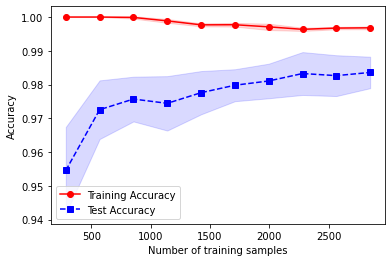

In [17]:
from sklearn.model_selection import learning_curve

%matplotlib inline

def show_learning_curve(clf, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(estimator=clf,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10)

    # 训练集集平均准确率
    train_mean = np.mean(train_scores, axis=1)

    # 训练集方差
    train_std = np.std(train_scores, axis=1)

    # 测试集平均准确率和方差
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # 训练集曲线设置
    plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
    # 训练集曲线范围
    plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

    # 测试集曲线设置
    plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
    plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
show_learning_curve(clf,features, gender)

### 6.2收集被错误预测的样本

In [18]:
clf = grid_obj.best_estimator_
pred = clf.predict(features)
wrong_pred = gender[pred != gender]
wrong_samples = []

# 将错误预测的样本加入wrong_pred
for i in wrong_pred.index:   
    row = data.loc[i]
    row['label'] = row['label'] + ' in SVM'
    wrong_samples.append(row)
            
pd.DataFrame(wrong_samples).to_csv('wrong_pred.csv')

print ('wrong data has been collected.')

wrong data has been collected.


D:\tmp\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### 6.3可视化异常分类样本的分布

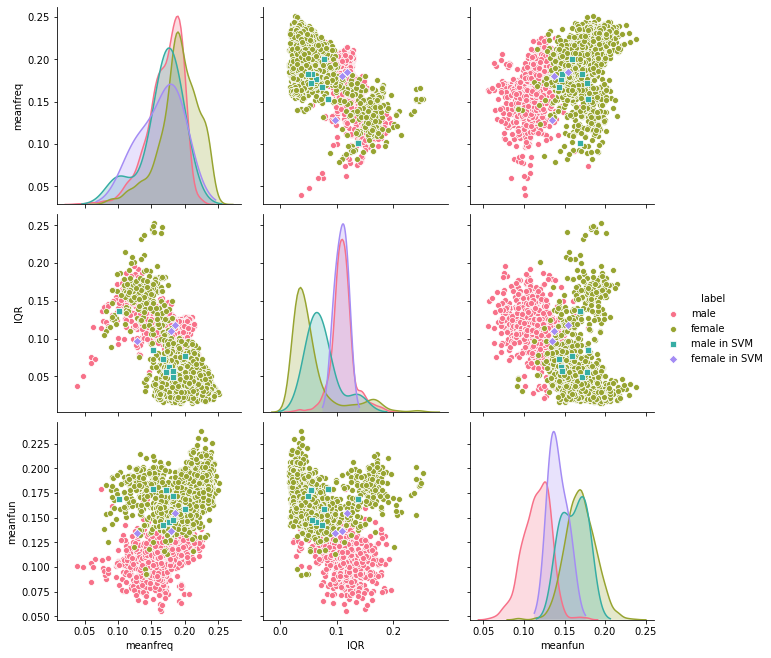

In [19]:
import seaborn

%matplotlib inline

# 合并原始样本和异常分类样本
data = pd.read_csv("voice.csv")
wrong_data = pd.read_csv("wrong_pred.csv")
data = pd.concat([data, wrong_data])

gender = data.label
features = data.drop(['label'], axis=1)
seaborn.pairplot(data[['meanfreq', 'IQR', 'meanfun', 'label']], 
            hue='label', palette="husl", markers=["o", "o", "s", "D"], height=3)
plt.show()

### 6.4输出最优模型在交叉验证上的准确率

In [20]:
# 获取最优模型
clf = svm.SVC(kernel='rbf', C=1.3, gamma=0.2)

data = pd.read_csv("voice.csv")
data = shuffle(data, random_state=0)
features = data.drop(['label'], axis=1)
gender = data.label
features = standard_data(features)
scores = cross_val_score(clf, features, gender, cv = 5, scoring='accuracy')

print ('Accuracy of the best model by cross_val_score:', np.mean(scores))

Accuracy of the best model by cross_val_score: 0.9835882282474145
